In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla
import scipy.io as sio
import meshio
import dolfin as dl

import localpsfcpp as lpsf

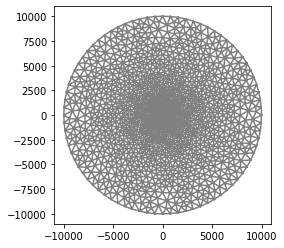

In [2]:
vertices = np.loadtxt('mesh_vertices.txt')
cells = np.loadtxt('mesh_cells.txt', dtype=int)
dof_coords = np.loadtxt('dof_coords.txt')
vertex_in_dof = np.loadtxt('vertex_in_dof.txt', dtype=int)
dof_in_vertex = np.loadtxt('dof_in_vertex.txt', dtype=int)

mesh_meshio = meshio.Mesh(vertices, [("triangle", cells)])
mesh_meshio.write("mesh.xml")
mesh = dl.Mesh("mesh.xml")
dl.plot(mesh)

In [3]:
Hdgn_array = np.loadtxt('Hdgn_array.txt')
sqrtR = sio.loadmat('sqrtR_matrix.mat')['sqrtR']
M = sio.loadmat('mass_matrix.mat')['M']
diag_M = np.loadtxt('mass_matrix_diagonal.txt')

apply_Hdgn = lambda x: np.dot(Hdgn_array, x)
apply_HdgnT = lambda x: np.dot(Hdgn_array, x)
apply_M = lambda x: M * x
solve_M = spla.factorized(M)
apply_ML = lambda x: x * diag_M
solve_ML = lambda x: x / diag_M

In [4]:
V = dl.FunctionSpace(mesh, 'CG', 1)

err_dof_coords = np.linalg.norm(dof_coords - V.tabulate_dof_coordinates()) / np.linalg.norm(V.tabulate_dof_coordinates())
print('err_dof_coords=', err_dof_coords)

err_dof_coords= 0.0


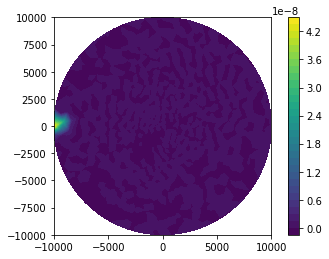

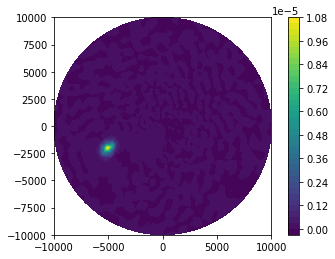

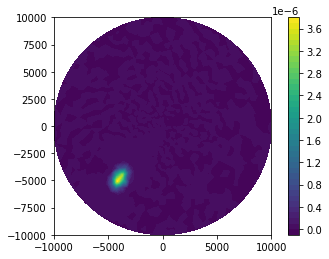

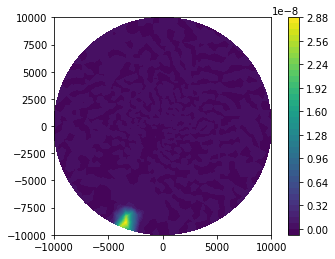

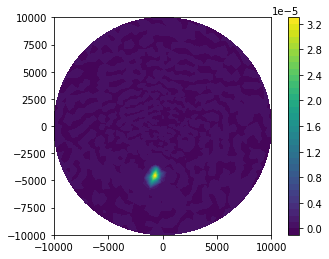

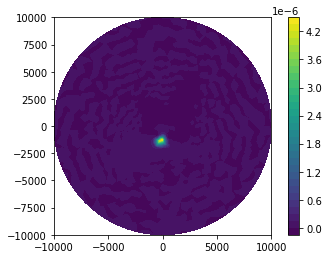

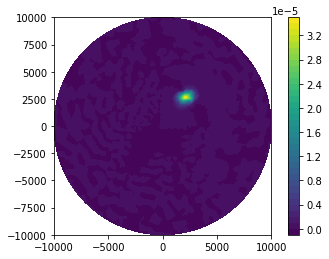

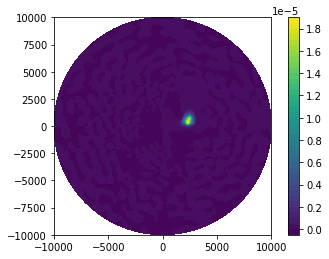

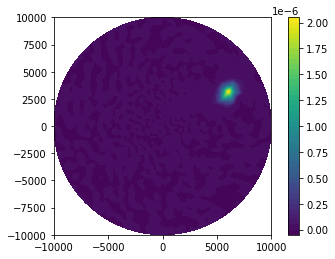

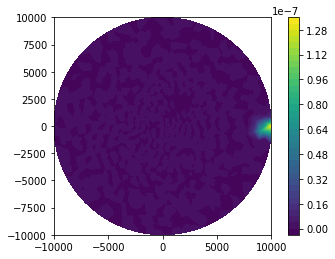

In [5]:
kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)

In [6]:
err_reorder = np.linalg.norm(dof_coords - vertices[dof_in_vertex,:]) / np.linalg.norm(dof_coords)
print('err_reorder=', err_reorder)

vertices_dof_order = np.array(vertices[dof_in_vertex,:].T, order='C')
cells_dof_order    = np.array(cells[dof_in_vertex,:].T,    order='C')

err_reorder= 0.0


In [7]:
vol, mu, Sigma = lpsf.compute_impulse_response_moments(apply_HdgnT, solve_ML, vertices_dof_order)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
processing V
processing mu
processing Sigma
done computing moments


In [8]:
from matplotlib.patches import Ellipse

def plot_ellipse(mu, Sigma, n_std_tau, ax=None, **kwargs):
    # Usage:
    #   https://github.com/NickAlger/nalger_helper_functions/tree/master/jupyter_notebooks/plot_ellipse.ipynb
    if ax is None:
        ax = plt.gca()

    ee, V = np.linalg.eigh(Sigma)
    e_big = ee[1]
    e_small = ee[0]
    v_big = V[:, 1]
    theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi

    long_length = n_std_tau * 2. * np.sqrt(e_big)
    short_length = n_std_tau * 2. * np.sqrt(e_small)

    if not ('facecolor' in kwargs):
        kwargs['facecolor'] = 'none'

    if not ('edgecolor' in kwargs):
        kwargs['edgecolor'] = 'k'

    ellipse = Ellipse(mu, width=long_length, height=short_length, angle=theta, **kwargs)
    ax.add_artist(ellipse)

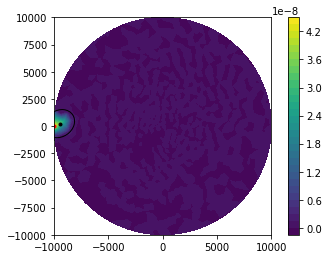

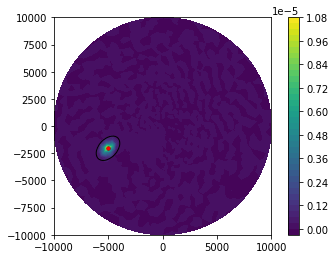

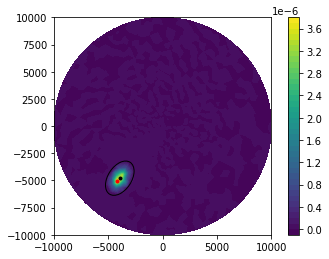

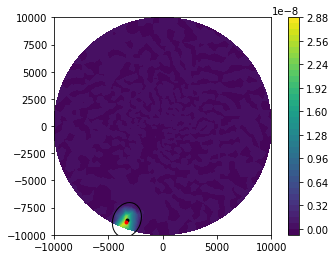

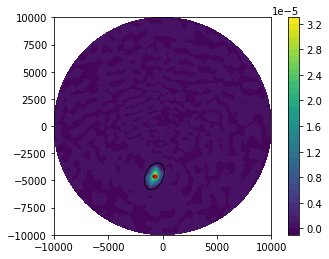

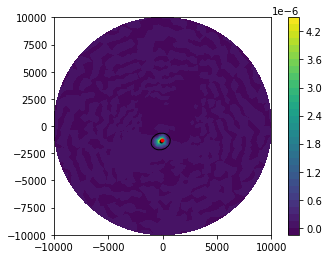

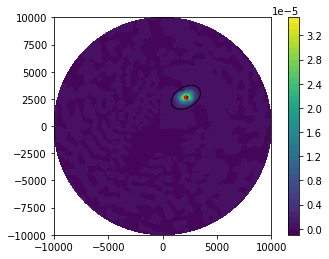

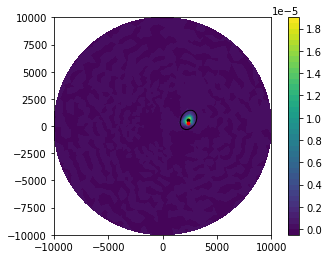

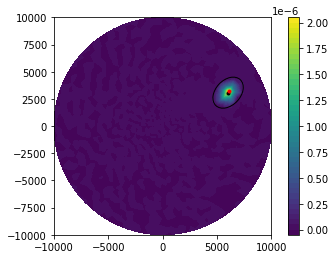

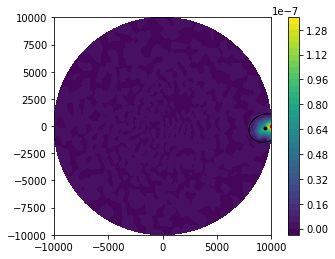

In [9]:
tau = 3.0

kk = list(np.linspace(0,V.dim()-1,10,dtype=int))
for k in kk:
    ek = np.zeros(V.dim())
    ek[k] = 1.0
    psi_k = dl.Function(V)
    psi_k.vector()[:] = solve_ML(apply_Hdgn(solve_ML(ek)))

    plt.figure()
    cm = dl.plot(psi_k)
    plt.colorbar(cm)
    plt.plot(mu[k][0], mu[k][1], '.k')
    plot_ellipse(mu[k], Sigma[k], tau, edgecolor='k')
    plt.plot(vertices_dof_order[0,k], vertices_dof_order[1,k], '.r')

In [19]:
num_neighbors = 10
min_vol_rtol = 1e-5
num_initial_batches = 5

lpsf_kernel = lpsf.create_LPSFKernel(apply_Hdgn, apply_HdgnT, apply_ML, apply_ML, solve_ML, solve_ML, 
                                    vertices_dof_order, vertices_dof_order, cells_dof_order, 
                                    tau, num_neighbors, min_vol_rtol, num_initial_batches)

computing V
computing mu
ii = 0
ii = 1
computing Sigma
ii = 0, jj = 0
ii = 1, jj = 0
ii = 1, jj = 1
processing V
processing mu
processing Sigma
done computing moments


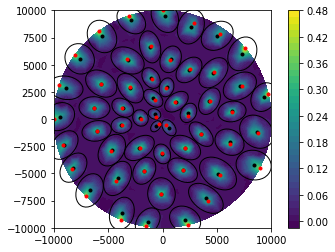

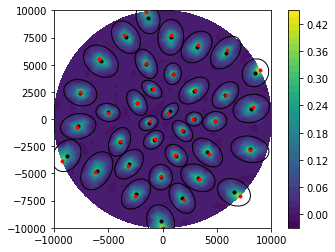

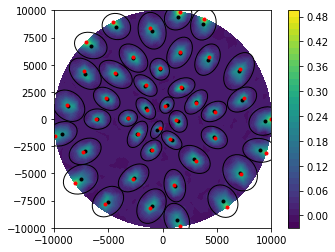

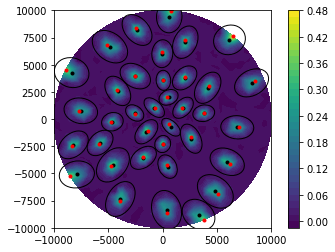

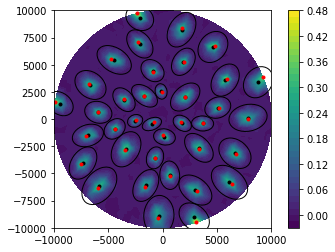

In [22]:
for b in range(len(lpsf_kernel.eta_batches)):
    eta_b = dl.Function(V)
    eta_b.vector()[:] = lpsf_kernel.eta_batches[b]

    plt.figure()
    cm = dl.plot(eta_b)
    plt.colorbar(cm)
    for ind in lpsf_kernel.dirac_ind_batches[b]:
        plt.plot(mu[ind][0], mu[ind][1], '.k')
        plot_ellipse(mu[ind], Sigma[ind], tau, edgecolor='k')
        plt.plot(vertices_dof_order[0,ind], vertices_dof_order[1,ind], '.r')